# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [109]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.10795607508290417
 0.4795465134883129
 0.45287687424996415
 0.024688319258530655
 0.8708882898899395
 0.26998204535857706
 0.6312959664826467
 0.7600879259321913
 0.5689179456491843
 0.9238803754536115
 ⋮
 0.4388674044003674
 0.6506042151133016
 0.07061730297483504
 0.818986536887363
 0.961549630384282
 0.18032547815754285
 0.3677053716189518
 0.6830626030277098
 0.6655569059857839

In [110]:
sum(a)

4.999404570796484e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [111]:
@time sum(a)

  0.003897 seconds (1 allocation: 16 bytes)


4.999404570796484e6

In [112]:
@time sum(a)

  0.004090 seconds (1 allocation: 16 bytes)


4.999404570796484e6

In [113]:
@time sum(a)

  0.003292 seconds (1 allocation: 16 bytes)


4.999404570796484e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [114]:
using Pkg
Pkg.add("BenchmarkTools")

   Resolving package versions...
  No Changes to `/mnt/c/Users/pauls/Desktop/Google Drive/PHSI365/Introduction-to-Julia/Project.toml`
  No Changes to `/mnt/c/Users/pauls/Desktop/Google Drive/PHSI365/Introduction-to-Julia/Manifest.toml`


In [115]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [116]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [117]:
c_sum(a)

4.999404570796097e6

In [118]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [119]:
c_sum(a) - sum(a)  

-3.8743019104003906e-7

In [120]:
≈  # alias for the `isapprox` function

isapprox (generic function with 18 methods)

In [121]:
?isapprox

ErrorException: syntax: invalid identifier name "?"

We can now benchmark the C code directly from Julia:

In [122]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 953 samples with 1 evaluation.
 Range (min … max):  4.542 ms …   8.831 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.180 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.230 ms ± 441.496 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

      ▂ ▁▄▂▅▁▅▄█▄▆▄▄▄▅▃▅▅▅▁▁▃▆▂▃▃▁▂ ▅▃      ▂                  
  ▆▆▇▅█▇███████████████████████████▇██▇▇▆▆▇▇█▅▄▅▃▃▄▂▄▃▃▃▂▂▁▂▃ ▆
  4.54 ms         Histogram: frequency by time        6.28 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [123]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 4.541589 msec


In [124]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 4.54159

In [125]:
using Plots
gr()

Plots.GRBackend()

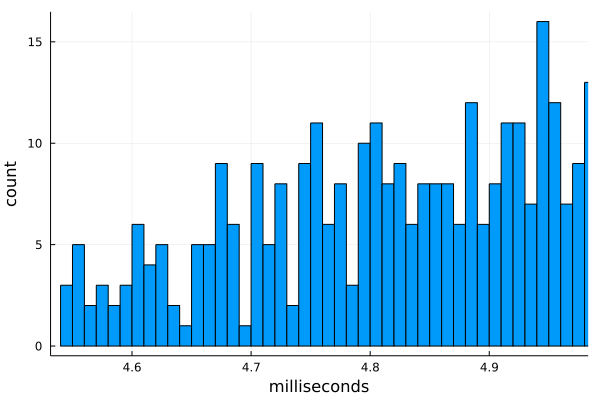

In [126]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [127]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [128]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 1429 samples with 1 evaluation.
 Range (min … max):  2.918 ms …   7.528 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.401 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.483 ms ± 434.241 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▇▇▃▄▅▃▄▄▇▅██▆▃▅▄▆▄▄ ▃▂▁                                     
  ▇███████████████████████▇▇▆▇▇▅▅▄▆▅▄▄▄▄▄▃▄▄▃▃▃▂▂▂▂▁▂▂▁▂▂▃▁▂▂ ▅
  2.92 ms         Histogram: frequency by time        4.94 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [129]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

2.91836

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [130]:
using Pkg; Pkg.add("PyCall")
using PyCall

   Resolving package versions...
  No Changes to `/mnt/c/Users/pauls/Desktop/Google Drive/PHSI365/Introduction-to-Julia/Project.toml`
  No Changes to `/mnt/c/Users/pauls/Desktop/Google Drive/PHSI365/Introduction-to-Julia/Manifest.toml`


In [131]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [132]:
pysum(a)

4.999404570796097e6

In [133]:
pysum(a) ≈ sum(a)

true

In [134]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 14 samples with 1 evaluation.
 Range (min … max):  353.261 ms … 363.225 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     357.939 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   358.107 ms ±   2.837 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁     ▁        ▁  ▁ █     ▁   ▁     ▁   ▁ ▁ ▁      ▁        ▁  
  █▁▁▁▁▁█▁▁▁▁▁▁▁▁█▁▁█▁█▁▁▁▁▁█▁▁▁█▁▁▁▁▁█▁▁▁█▁█▁█▁▁▁▁▁▁█▁▁▁▁▁▁▁▁█ ▁
  353 ms           Histogram: frequency by time          363 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [135]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 4.54159
  "Python built-in" => 353.261
  "C -ffast-math"   => 2.91836

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [136]:
using Pkg; Pkg.add("Conda")
Pkg.build("PyCall")
using Conda

   Resolving package versions...
  No Changes to `/mnt/c/Users/pauls/Desktop/Google Drive/PHSI365/Introduction-to-Julia/Project.toml`
  No Changes to `/mnt/c/Users/pauls/Desktop/Google Drive/PHSI365/Introduction-to-Julia/Manifest.toml`
    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/6e47d11ea2776bc5627421d59cdcc1296c058071/build.log`
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/1fc929f47d7c151c839c5fc1375929766fb8edcc/build.log`


In [137]:
Conda.add("numpy")

Solving environment: ...working... done

# All requested packages already installed.



┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda /home/pablo/.julia/packages/Conda/x2UxR/src/Conda.jl:127


In [138]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 1448 samples with 1 evaluation.
 Range (min … max):  2.948 ms …   4.876 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.405 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.441 ms ± 311.252 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▃▇▆█▃▄▅▂▁▂▁▁▅▅█▇▄▅▅▅▂▁▃▃▃▅▁▁ ▁                             
  ▂▄██████████████████████████████▆▇█▇▅▃▃▅▄▃▃▄▄▄▂▃▂▃▂▁▂▁▂▂▁▂▁ ▅
  2.95 ms         Histogram: frequency by time        4.38 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [139]:
numpy_sum(a)

4.999404570796484e6

In [140]:
numpy_sum(a) ≈ sum(a)

true

In [141]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 4.54159
  "Python numpy"    => 2.94775
  "Python built-in" => 353.261
  "C -ffast-math"   => 2.91836

# 5. Python, hand-written 

In [142]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7fb077b156c0>

In [143]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 13 samples with 1 evaluation.
 Range (min … max):  409.027 ms … 417.825 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     414.373 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   414.306 ms ±   2.374 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁                    ▁   █    ▁    ▁ ▁▁         ▁ ▁█        ▁  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁█▁▁▁▁█▁▁▁▁█▁██▁▁▁▁▁▁▁▁▁█▁██▁▁▁▁▁▁▁▁█ ▁
  409 ms           Histogram: frequency by time          418 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [144]:
sum_py(a)

4.999404570796097e6

In [145]:
sum_py(a) ≈ sum(a)

true

In [146]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 4.54159
  "Python numpy"        => 2.94775
  "Python hand-written" => 409.027
  "Python built-in"     => 353.261
  "C -ffast-math"       => 2.91836

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [147]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:889

In [148]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 1698 samples with 1 evaluation.
 Range (min … max):  2.433 ms …   5.131 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.862 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.928 ms ± 361.236 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▃██▂▅▄▃▄▁▃▄▂ ▃▂▄▂ ▂                                        
  ▂▅██████████████████████▆▇▅▅▅▄▆▄▃▃▃▄▃▃▃▂▂▂▂▂▁▂▂▁▁▁▂▂▁▁▁▁▁▁▁ ▄
  2.43 ms         Histogram: frequency by time        4.16 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [149]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 4.54159
  "Python numpy"        => 2.94775
  "Python hand-written" => 409.027
  "Python built-in"     => 353.261
  "Julia built-in"      => 2.43313
  "C -ffast-math"       => 2.91836

# 7. Julia (hand-written) 

In [150]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [151]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 973 samples with 1 evaluation.
 Range (min … max):  4.581 ms …   7.857 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.044 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.121 ms ± 342.249 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

       ▁▁▆▅▇▇█▆▄▇▅▃▃▁▂▁▃▂▃▁    ▂ ▁    ▁▂                       
  ▃▅▆▇█████████████████████▄▇█▆███▇▇████▇▆▅▄▅▅▅▄▄▃▃▄▃▄▃▃▁▃▁▁▃ ▅
  4.58 ms         Histogram: frequency by time        6.04 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [152]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "C"                   => 4.54159
  "Python numpy"        => 2.94775
  "Julia hand-written"  => 4.58081
  "Python hand-written" => 409.027
  "Python built-in"     => 353.261
  "Julia built-in"      => 2.43313
  "C -ffast-math"       => 2.91836

# 8. Julia (hand-written w. simd) 

In [153]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [154]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 1797 samples with 1 evaluation.
 Range (min … max):  2.362 ms …   4.268 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.707 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.767 ms ± 305.845 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▇▆█▃▂▅▃▂▁▂▁  ▁▁ ▃                                          
  ▅▇██████████████████████▇█▆▅█▆▆▆▄▅▄▅▄▅▅▃▄▃▄▃▃▃▃▃▂▃▁▃▃▂▂▃▂▂▂ ▄
  2.36 ms         Histogram: frequency by time         3.7 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [155]:
mysum_simd(a)

4.999404570796498e6

In [156]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 2.36217
  "C"                       => 4.54159
  "Python numpy"            => 2.94775
  "Julia hand-written"      => 4.58081
  "Python hand-written"     => 409.027
  "Python built-in"         => 353.261
  "Julia built-in"          => 2.43313
  "C -ffast-math"           => 2.91836

# Summary

In [157]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Julia hand-written simd.....2.4
Julia built-in..............2.4
C -ffast-math...............2.9
Python numpy................2.9
C...........................4.5
Julia hand-written..........4.6
Python built-in...........353.3
Python hand-written.......409.0
